In [50]:
%matplotlib inline

In [82]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display
import numpy as np
import math

In [235]:
class Body(plt.Circle):

    G = 0.00002
    def __init__(self, x,y,mass,radius = 0.2,color='green'):
        self.x = x
        self.y = y
        self.mass = mass
        self.body = plt.Circle((self.x,self.y), radius = radius,color = color)
        self.velocity = np.array([0,0])
    
    @staticmethod
    def calc_acceleration(M,r):
        return Body.G * M/r**2

    @staticmethod
    def distance(point1,point2):
        return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)
    
    @staticmethod
    def first_derivative(M,r):
        return 2 * Body.G * M/ r **3
    
    @staticmethod
    def escape_velocity(M,r):
        return math.sqrt(2 * M * Body.G/ r)
    
    

    @staticmethod
    def calc_new_positions(body1, body2,dist):
        
        dist_vector = [body2.x - body1.x, body2.y - body1.y]
        first_deriv = body1.first_derivative(body2.mass, dist)    
        velocity_vector = np.array([dist_vector[0] * first_deriv, dist_vector[1] * first_deriv])    
        body1.velocity = body1.velocity + velocity_vector
        body1.x += body1.velocity[0]
        body1.y += body1.velocity[1]
        return body1.x, body1.y
    
circleA = Body(0,0,200,radius= 0.3)
# circleA.velocity = np.array([0,0])
circleB = Body(5,1, 5, radius= 0.1,color='red')


circleB.velocity = np.array([-0.02, 0.03])


dist = circleA.distance([circleA.x, circleA.y], [circleB.x, circleB.y])
print(f'Acceleration: {circleA.calc_acceleration(circleA.mass, dist)} Distance: {dist} First derivative:\
      {circleA.first_derivative(circleA.mass, dist)} Escape velocity: {circleB.escape_velocity(circleA.mass,dist)}')

fig = plt.figure(figsize= (5,5))
ax = fig.add_subplot(111)
ax.add_artist(circleA.body)
ax.add_artist(circleB.body)

lines = plt.plot([])
line = lines[0]


plt.xlim(-10,10)
plt.ylim(-10,10)

def animate(frame):
    #Calculate current distance between the bodies
    dist = circleA.distance([circleA.x, circleA.y], [circleB.x, circleB.y])
    
    #Calculate new posititions of the two bodies
    circleB.x,circleB.y = circleB.calc_new_positions(circleB,circleA,dist)
    circleA.x, circleA.y = circleA.calc_new_positions(circleA,circleB,dist)    

    circleA.body.center = (circleA.x, circleA.y)
    circleB.body.center = (circleB.x, circleB.y)
    line.set_data((circleA.x,circleA.y))
    line.set_data((circleB.x, circleB.y))
    
    
anim = FuncAnimation(fig, animate,frames=1000, interval=10)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

Acceleration: 0.00015384615384615388 Distance: 5.0990195135927845 First derivative:      6.0343426196364335e-05 Escape velocity: 0.039609709429702614


4.242640687119285
[0 0]
[3 3]
[-3 -3]
Result vector: 
    Specialized PolyCollection for arrows.

    The only API method is set_UVC(), which can be used
    to change the size, orientation, and color of the
    arrows; their locations are fixed when the class is
    instantiated.  Possibly this method will be useful
    in animations.

    Much of the work in this class is done in the draw()
    method so that as much information as possible is available
    about the plot.  In subsequent draw() calls, recalculation
    is limited to things that might have changed, so there
    should be no performance penalty from putting the calculations
    in the draw() method.
    


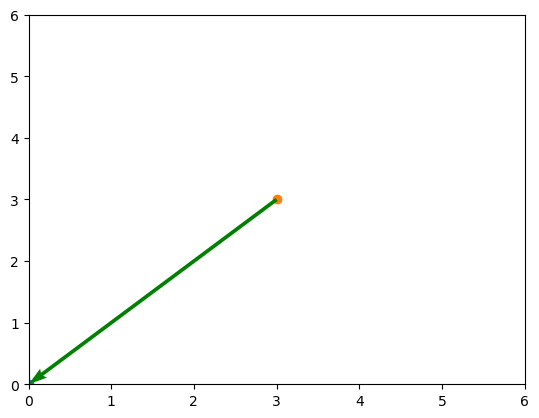

In [138]:
def calc_distance(v1,v2):
    return math.sqrt((v1[0] - v2[0]) **2 + (v1[1] - v2[1])**2)

A = np.array([0,0])
B = np.array([3,3])
d = circleA.distance(A,B)
print(d)
print(A)
print(B)
print(A+(-1)* B)
plt.xlim(0,6)
plt.ylim(0,6)
plt.scatter(0,0)
plt.scatter(3,3)
result = plt.quiver(3,3,-3,-3, angles = "xy", scale_units = "xy", scale = 1, color = 'green')
print(f'Result vector: {result.__doc__}')
# plt.quiver(0,0,1,1, angles = "xy", scale_units = "xy", scale = 1, color = 'red')
# plt.quiver(0,0,3,3, angles = "xy", scale_units = "xy", scale = 1, color = 'blue')

plt.show()


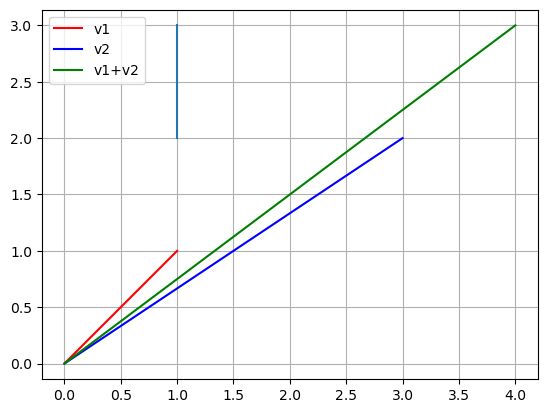

In [80]:
# Векторите
v1 = np.array([1, 1])
v2 = np.array([3, 2])

# Изчисляване на сумата
v_sum = v1 + v2

# Начертаване на графиката
plt.figure()
plt.plot([0, v1[0]], [0, v1[1]], '-r', label='v1') # Червената линия е v1
plt.plot([0, v2[0]], [0, v2[1]], '-b', label='v2') # Синята линия е v2
plt.plot([0, v_sum[0]], [0, v_sum[1]], '-g', label='v1+v2') # Зелената линия е v1+v2
plt.plot([1,1], [3,2])
plt.legend(loc='upper left')
plt.axis('equal')
plt.grid()
plt.show()